<a href="https://colab.research.google.com/github/so-dipe/Internships/blob/main/Fellowship.ai/IMDB_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#download dataset from kaggle
#To run this code, you will need to create a kaggle API and store in on your google drive
from google.colab import drive
drive.mount('/content/drive') 

#get dataset from kaggle with API
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

#unzip dataset
! unzip /content/imdb-dataset-of-50k-movie-reviews.zip

Mounted at /content/drive
 43% 11.0M/25.7M [00:00<00:00, 115MB/s]
100% 25.7M/25.7M [00:00<00:00, 195MB/s]
Archive:  /content/imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [2]:
#import libraries
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from bs4 import BeautifulSoup
import re

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, auc, log_loss
from sklearn.pipeline import make_pipeline

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Bidirectional, Dropout, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics

import warnings

warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Sentiment Analysis on the IMDB Dataset


This notebook focuses on sentiment analysis on the IMDB dataset. The notebook is divided into three parts, Data Exploration, Modelling and Model Evaluation

##Explore

In [3]:
imdb_data = pd.read_csv("/content/IMDB Dataset.csv")
imdb_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


At first glance, the dataset doesn't look like much. It only has two columns, one containing the review and the other containing the sentiment. Before diving into the columns, it's important to check for null values and the size of the dataset.

In [ ]:
imdb_data.isna().sum()

review       0
sentiment    0
dtype: int64

In [ ]:
imdb_data.shape

(50000, 2)

From the above, we can see that the dataset contains two columns as we saw already and 50k rows or examples.

Next, we review the columns starting with `sentiment`. From what I can see, there seem to be only two entries in the column (positive or negative). We can check if there are any other values in this column and count all the different values present.

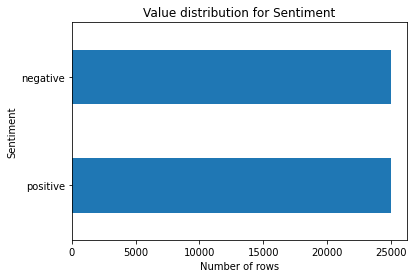

In [ ]:
imdb_data['sentiment'].value_counts().plot(kind='barh')
plt.xlabel('Number of rows')
plt.ylabel('Sentiment')
plt.title('Value distribution for Sentiment');

The plot above shows that we have balanced dataset with exactly half of the columns having a positive or negative sentiment.

We now have to work on the `review` column

In [ ]:
imdb_data['review'].head(5)

0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
2    I thought this was a wonderful way to spend ti...
3    Basically there's a family where a little boy ...
4    Petter Mattei's "Love in the Time of Money" is...
Name: review, dtype: object

The result is truncated and this does not show much 

In [4]:
line_width = 175
for review in imdb_data['review'].head(2):
    # Wrap text to specified line width and print
    wrapped_text = textwrap.fill(review, width=line_width)
    print(wrapped_text)
    print('\n')
print("-"*100)

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first
thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or
timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname
given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face
inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares,
dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

Well, that's a lot of text and we still need to carry out further analysis but first, we have to clean the reviews. One thing that is very noticable is the continuous occurence of `<br/><br>` . This is html syntax and we don't need it. Although, this looks like the only one form of html syntax present, it would be safer to remove all occurence of html syntax.

In [ ]:
imdb_data['review'] = imdb_data['review'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

for review in imdb_data['review'].head(1):
    # Wrap text to specified line width and print
    wrapped_text = textwrap.fill(review, width=line_width)
    print(wrapped_text)
    print('\n')

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.The first thing that
struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This
show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald
Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy
is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and
shady agreements are never far away.I would say the main appeal of the show is due to the fact that it goes where other shows wou

As we can see, the html syntax is now gone. You can compare this output with the first fully print review above.

Next, we can remove all puntuations as they offer no value to our analysis and or model.

In [ ]:
# Remove unwanted characters like puntuattions
imdb_data['review'] = imdb_data['review'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))

for review in imdb_data['review'].head(1):
    # Wrap text to specified line width and print
    wrapped_text = textwrap.fill(review, width=line_width)
    print(wrapped_text)
    print('\n')

One of the other reviewers has mentioned that after watching just 1 Oz episode you ll be hooked  They are right  as this is exactly what happened with me The first thing that
struck me about Oz was its brutality and unflinching scenes of violence  which set in right from the word GO  Trust me  this is not a show for the faint hearted or timid  This
show pulls no punches with regards to drugs  sex or violence  Its is hardcore  in the classic use of the word It is called OZ as that is the nickname given to the Oswald
Maximum Security State Penitentary  It focuses mainly on Emerald City  an experimental section of the prison where all the cells have glass fronts and face inwards  so privacy
is not high on the agenda  Em City is home to many  Aryans  Muslims  gangstas  Latinos  Christians  Italians  Irish and more    so scuffles  death stares  dodgy dealings and
shady agreements are never far away I would say the main appeal of the show is due to the fact that it goes where other shows wou

Here, we remove all puntuations as they offer no value to our analysis going forward. I replaced them with a whitespace character. 

Converting all text to lower case will also be helpful since strings are case-sensitive and in this context using "**the**" or "**The**" makes no significant difference

In [ ]:
# Convert all text to lowercase
imdb_data['review'] = imdb_data['review'].apply(lambda x: x.lower())

In [ ]:
#remove all stopwords
stop_words = set(stopwords.words('english'))

imdb_data['review'] = imdb_data['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

for review in imdb_data['review'].head(1):
    # Wrap text to specified line width and print
    wrapped_text = textwrap.fill(review, width=line_width)
    print(wrapped_text)
    print('\n')

one reviewers mentioned watching 1 oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint
hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald
city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death
stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm
forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice
crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack street skil

After completing the cleaning process, next we try to do some analysis. First we create a word cloud for each of the sentiment (positive and negative) to see what words are most frequently used by both classes.

In [ ]:
def generate_wordcloud(text):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(text) 
    return wordcloud

positive_reviews = imdb_data[imdb_data['sentiment'] == 'positive']
negative_reviews = imdb_data[imdb_data['sentiment'] == 'negative']

In [ ]:
# Generate word cloud for positive reviews
positive_text = ' '.join(positive_reviews['review'])
positive_wordcloud = generate_wordcloud(positive_text)

# Generate word cloud for negative reviews
negative_text = ' '.join(negative_reviews['review'])
negative_wordcloud = generate_wordcloud(negative_text)

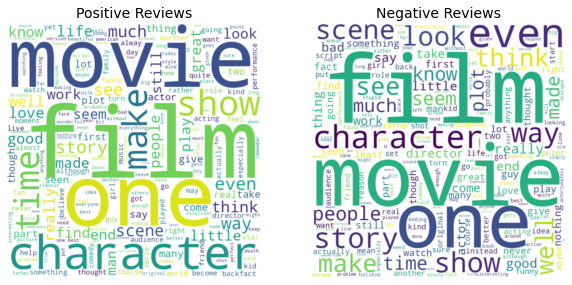

In [ ]:
# Create figure and subplots
fig, axs = plt.subplots(figsize=(10, 10), ncols=2)

# Display word cloud for positive reviews
axs[0].imshow(positive_wordcloud, interpolation='bilinear')
axs[0].set_title('Positive Reviews', fontsize=14)
axs[0].axis('off')

# Display word cloud for negative reviews
axs[1].imshow(negative_wordcloud, interpolation='bilinear')
axs[1].set_title('Negative Reviews', fontsize=14)
axs[1].axis('off')

# Show plot
plt.show()

From the Word Cloud above, we see that the most used words in positive reviews are also heavily used in negative reviews. But words have more context when with other words. 

## Model


In this part, we focus on building a Sentiment Analysis model. There are a lot of machine learning models that can be used for sentiment analysis. I will first start with a simple baseline model and try to improve on that.

But first, we need to create a data cleaning/transformation pipeline.

In [ ]:
def text_cleaning_pipeline(text_column):
    # Remove html syntax
    text_column = text_column.apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

    # Remove unwanted characters like puntuattions
    text_column = text_column.apply(lambda x: re.sub(r'[^\w\s]', ' ', x))

    # Convert all text to lowercase
    text_column = text_column.apply(lambda x: x.lower())

    #remove all stopwords
    stop_words = set(stopwords.words('english'))
    text_column = text_column.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

    return text_column


This function would help with converting new reviews to a format suitable for our model. It just brings together all the data cleaning steps we used earlier.


In [ ]:
imdb_data = pd.read_csv("/content/IMDB Dataset.csv")

X = imdb_data['review']
y = imdb_data['sentiment']

y[y == 'positive'] = 0
y[y == 'negative'] = 1
y = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
X_train = text_cleaning_pipeline(X_train)

In [ ]:
X_test = text_cleaning_pipeline(X_test)

Here, we split the dataset into two subsets, one for training and the other for evaluating the model's performance. I have chosen to use 80% of the model for training and 20% for testing. The target here is the sentiment and from the dataset, is either "positive" or "negative", to make it work with the models we will be training, I have changed them to `0` for positive and `1` for negative.

This problem is a binary classification task and thus we will be using a couple of classification algorithms.

--**Baseline Model**--

We start with a simple baseline model using logistic regression. Normally, an initial baseline would be to assign all reviews to the sentiment with the most reviews from the dataset. There, that would give us an accuracy score of ~50%. This is a good as random guess but it gives us a good place to improve from.

In [ ]:
base_clf = make_pipeline(CountVectorizer(), LogisticRegression())
base_clf.fit(X_train, y_train)
print('Baseline Accuracy Training Score:', base_clf.score(X_train, y_train))

Baseline Accuracy Training Score: 0.99595


For the baseline, I have created a training pipeline that converts the reviews into a bag of words matrix. The `CountVectorizer` does this. The bag of words simply counts how many times a word from the vocabulary appears in each review. The words in the vocabulary are represented by the column of a matrix and each row is a review. As the vocabulary gets bigger, so does the matrix but it is usually mostly sparse (containing a lot of zeros).

In [ ]:
y_pred = base_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

Accuracy: 0.8897


The baseline model does too well on the training set and there is a performance drop on the test set but there is no real reason to panic yet. According to papers with code, most SOTA deep learning models trained on this dataset achieve similar accuracy. Even model like BERT were only able to get an accuracy score of ~90%.

Before we settle on this model, We should try a cross validation strategy with 5 folds.

In [ ]:
cv_score = cross_val_score(base_clf, X_train, y_train, cv=5)
for i in range(len(cv_score)):
    print(f'CV score for fold {i}: {cv_score[i]}')

CV score for fold 0: 0.88125
CV score for fold 1: 0.884875
CV score for fold 2: 0.88425
CV score for fold 3: 0.88125
CV score for fold 4: 0.8795


The performance across the 5 folds are pretty similar and this confirms that this model is pretty good.

Next, we try a LSTM model. LSTM are a form of Deep Learning models and they are very good for NLP tasks. 

In [ ]:
#Create a Validation subset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Tokenize the text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)

# Pad the sequences
max_len = 200
X_train_seq = pad_sequences(X_train_seq, maxlen=max_len)
# X_val_seq = pad_sequences(X_val_seq, maxlen=max_len)
# X_test_seq = pad_sequences(X_test_seq, maxlen=max_len)

def lstm_input_pipeline(text, tokenizer, max_len):
    text_seq = tokenizer.texts_to_sequences(text)
    text_seq = pad_sequences(text_seq, maxlen=max_len)
    return text_seq

X_val_seq = lstm_input_pipeline(X_val, tokenizer, max_len)
x_test_seq = lstm_input_pipeline(X_test, tokenizer, max_len)

# Define the model
inputs = Input(shape=(max_len,))
embedding = Embedding(input_dim=10000, output_dim=128)(inputs)
lstm = Bidirectional(LSTM(units=64, dropout=0.5, recurrent_dropout=0.5))(embedding)
outputs = Dense(units=1, activation='sigmoid')(lstm)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', metrics.AUC(curve='ROC')])

# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train_seq, y_train, validation_data=(X_val_seq, y_val), batch_size=128, epochs=50, callbacks=[early_stopping], verbose=0)

print(history)


This code creates a LSTM model with tensorflow. The model takes a sequence of words as input which is different from the Logistic Regression model we created earlier. Models like the LSTM are very good with sequence data like the one we have here. I have also included a callback to stop training the model when validation loss starts getting worse.

In [ ]:
# Print the last epoch info from history object
print("Last epoch training loss: ", history.history['loss'][-1])
print("Last epoch validation loss: ", history.history['val_loss'][-1])
print("Last epoch training accuracy: ", history.history['accuracy'][-1])
print("Last epoch validation accuracy: ", history.history['val_accuracy'][-1])

Last epoch training loss:  0.10432934015989304
Last epoch validation loss:  0.5669127106666565
Last epoch training loss:  0.9643555283546448
Last epoch validation loss:  0.8598666787147522


From the information above, the LSTM model does not perform better than the Baseline model we created earlier. 

In [ ]:
loss, accuracy, roc_auc = model.evaluate(x_test_seq, y_test, batch_size=128)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')
print(f'Test ROC AUC score: {roc_auc:.4f}')


79/79 [==============================] - 21s 262ms/step - loss: 0.3370 - accuracy: 0.8583 - auc: 0.9373


As we can see, the performance of the LSTM and baseline (logistic regression) model differs a little. The accuracy is score of the baseline is better, the LSTM has a better loss but it's AUC isn't as good as the baseline. 

Although we could try other models, and the model that actually performs best on this data being the `XLNet`. It is however resource heavy and takes why longer time to run.

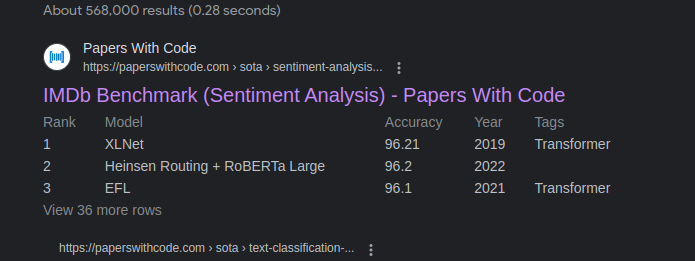


I am therefore going to continue to the evaluation section of this notebook using the Baseline model (Logistic Regression) since it outperforms the LSTM. And is much faster.


## Evaluation

Here, we evaluate the model of choice (Logistic Regression) looking at important metrics like precision, recall, roc_auc etc...

In [ ]:
y_pred = base_clf.predict(X_test)
y_pred_proba = base_clf.predict_proba(X_test)

log_loss_score = log_loss(y_test, y_pred_proba)
print("Log loss: {:.4f}".format(log_loss_score))


Log loss: 0.3553


We start with the log loss. The model has a log loss score of **0.3553**, which is close to zero.

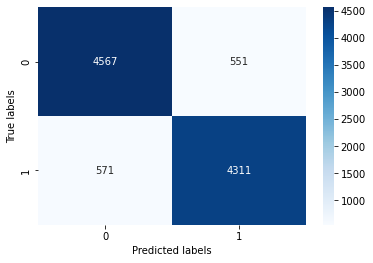

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()


Next, we have a confusion matrix which shows the number of true positives and true negatives from the test set. It also shows the number of misclassified examples in terms of False Positives and False Negatives. 

Here, we have a False Positive of **551** which means that the model predicted this many examples as having a *Negative* sentiment when they were actually *Positive* and we also have a False Negative of **571** which means the model predicted that many reviews as *Positive* sentiment when they were infact negative.

The correctly predicted reviews are actually way more and this means the model does pretty well.

In [ ]:
y_pred = base_clf.predict(X_test)
y_pred_proba = base_clf.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Report: \n{report}")

Accuracy: 0.8878
Report: 
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      5118
           1       0.89      0.88      0.88      4882

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



The baseline model has good recall and precision scores. The recall shows that the model identifies the correct sentiment about 89% of the time and the precision tell us that of the sentiment predicted, how many were actually correct and in this case it got a score of 89% on both the positive and negative sentiment. 

The f1-score which is a derivation of the fβ score (where β = 1) tries to balance both precision and recall and here it also gets a score of 89%. Therefore, we can conclude that the model does a good job (not perfect but very good). 

One last metric to look at is the Reciver Operating Characteristic Curve (ROC curve) and the Area under the Curve (AOC). This will tell us if the model is just guessing randomly (AOC: 0.5) or making good predictions (max AOC: 1). A value close to one is the goal here.

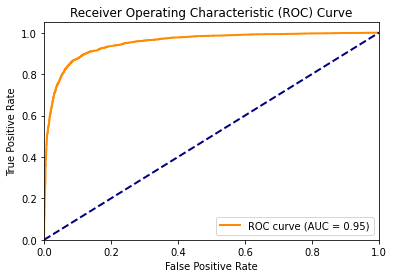

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


The ROC curve shows that the model does a very good job with an AUC score of 0.95. This shows that the classifier is doing a very good job and isn't just guessing. 

## Inference

Here, I am going to try some review examples and see what the model outputs. I have compiled a list of reviews from recent movies (2022-2023) which are out of the scope of the training dataset. 

In [ ]:
url = 'https://raw.githubusercontent.com/so-dipe/Internships/main/Fellowship.ai/movies%20review.csv'
response = requests.get(url)

with open('movies_review.csv', 'wb') as file:
    file.write(response.content)

In [ ]:
movies_review = pd.read_csv('/content/movies_review.csv')
movies_review.head()

,review,imdb rating
0,This was such a fun movie to watch. It was lon...,10/10
1,I am conflicted with this film and with Marvel...,6/10
2,"So, the dumbest thing they could have possibly...",4/10
3,James Cameron gives James Bond's Thunderball c...,6/10
4,I just got out of The Batman\n\nThis movie rea...,8/10


The file contains 10 reviews and their imdb ratings for comparison.

In [ ]:
clean_reviews = text_cleaning_pipeline(movies_review['review'])

We pass the file through the text cleaning pipeline for prepare it for our model.

In [ ]:
movies_review['sentiment'] = base_clf.predict(clean_reviews)
# movies_review['sentiment probability'] = base_clf.predict_proba(clean_reviews)[:, 1].round(2)
movies_review['sentiment'][movies_review['sentiment'] == 0] = 'positive'
movies_review['sentiment'][movies_review['sentiment'] == 1] = 'negative'
movies_review.head(10)

,review,imdb rating,sentiment
0,This was such a fun movie to watch. It was lon...,10/10,positive
1,I am conflicted with this film and with Marvel...,6/10,positive
2,"So, the dumbest thing they could have possibly...",4/10,negative
3,James Cameron gives James Bond's Thunderball c...,6/10,negative
4,I just got out of The Batman\n\nThis movie rea...,8/10,positive
5,Matt Reeves is not a good director at all-- -h...,3/10,negative
6,I watch and re-watch a lot of movies per year ...,1/10,negative
7,Visual Orgy of Visual Metaphors That Get Old W...,5/10,negative
8,Sticking to the lower budget roots that got hi...,7/10,positive
9,Jason Statham and Guy Ritchie ... some might c...,9/10,positive


The model does a pretty good job, with reviews with a 7 or higher rating getting a positive sentiment and reviews with a 4 or lower rating getting a negative sentiment. The only struggle is with reviews between 5 and 6. This is to be expected as this is an average point and reviews around here can be either bad or good.

Unfortunately, I will not be investigating this any further.